# Fundamentals of Software Systems (FSS)
**Software Evolution – Part 02 Assignment**

## Submission Guidelines

To correctly complete this assignment you must:
* Carry out the assignment in a team of 2 to 4 students.
* Carry out the assignment with your team only. You are allowed to discuss solutions with other teams, but each team should come up its own personal solution. A strict plagiarism policy is going to be applied to all the artifacts submitted for evaluation.
* As your submission, upload the filled Jupyter Notebook (including outputs) together with the d3 visualization web pages (i.e. upload everything you downloaded including the filled Jupyter Notebook plus your `output.json`)
* The files must be uploaded to OLAT as a single ZIP (`.zip`) file by Dec 12, 2022 @ 23:55.


## Group Members
<i>Alexander Christian Lerch       17-678-111 

Szymon Kaczmarski               21-743-778 

Luis Torrejón Machado           21-721-097 </i>



## Task Context

In this assigment we will be analyzing the _elasticsearch_ project. All following tasks should be done with the subset of commits from tag `v1.0.0` to tag `v1.1.0`.

Website: https://github.com/elastic/elasticsearch
Repository: https://github.com/elastic/elasticsearch.git

In [1]:
import pydriller
import numpy as np
import matplotlib.pyplot as plt
import json
import csv
from collections import defaultdict
from datetime import datetime as dt
from tqdm import tqdm

from bokeh.plotting import figure, show, output_notebook, output_file, reset_output
from bokeh.models import ColumnDataSource, CategoricalColorMapper, PrintfTickFormatter, NumeralTickFormatter, Legend, CDSView, GroupFilter, CustomJS, BoxSelectTool, FactorRange
from bokeh.layouts import gridplot, column
from bokeh.models.widgets import Div
from bokeh.palettes import Spectral6, Pastel1, Category20c, Inferno256
output_notebook()

from enum import Enum 
class Modification(Enum):
    ADDED = "Lines added"
    REMOVED = "Lines removed"
    TOTAL = "Lines added + lines removed"
    DIFF = "Lines added - lines removed"

Loading BokehJS ...

## Task 1: Author analysis

In the following, please consider only `java` files.

The first task is to get an overview of the author ownership of the _elasticsearch_ project. In particular, we want to understand who are the main authors in the system between the two considered tags, the authors distribution among files and the files distribution among authors. To this aim, perform the following:
- create a dictionary (or a list of tuples) with the pairs author => number of modified files
- create a dictionary (or a list of tuples) with the pairs file => number of authors who modified the file
- visualize the distribution of authors among files: the visualization should have on the x axis the number of authors per file (from 1 to max), and on the y axis the number of files with the given number of authors (so for example the first bar represent the number of files with single author)
- visualize the distribution of files among authors: the visualization should have on the x axis the number of files per author (from 1 to max), and on the y axis the number of authors who modified the given number of files (so for example the first bar represent the minor contributors, i.e., the number of authors who changed only 1 file)

Comment the two distribution visualizations.

In [2]:
elastic_path = "C:\\Users\\szymo\\Desktop\\SOSy_repos\\elasticsearch"
# elastic_path = "C:\\Users\\luist\\OneDrive\\Escritorio\\SOSY-SE-ASSIGNMENT\\elastic\\elasticsearch"
repo = pydriller.Repository(elastic_path, from_tag="v1.0.0", to_tag="v1.1.0")

In [4]:
# dictionary author => number of modified files
authors_nmodif_dictionary = {}
for c in repo.traverse_commits():
    for mf in c.modified_files:
        if mf.new_path:
            if mf.new_path.endswith('.java'):
                if c.author.name not in authors_nmodif_dictionary:
                    authors_nmodif_dictionary[c.author.name] = 1
                else:
                    authors_nmodif_dictionary[c.author.name] += 1 
        else:
            if mf.old_path.endswith('.java'):
                if c.author.name not in authors_nmodif_dictionary:
                    authors_nmodif_dictionary[c.author.name] = 1
                else:
                    authors_nmodif_dictionary[c.author.name] += 1  
authors_nmodif_dictionary = {k: v for k, v in sorted(authors_nmodif_dictionary.items(), 
                                                        key=lambda item: item[1], reverse=True)}

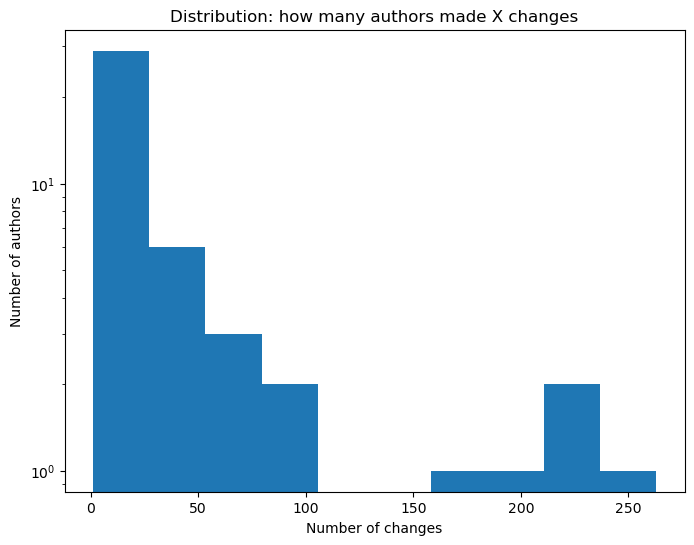

In [25]:
# visualization: number of authors (y) who modified n files (x)
plt.figure(figsize=(8,6))
plt.title("Distribution: how many authors made X changes", fontsize=12)
plt.hist(list(authors_nmodif_dictionary.values()), bins=10)
plt.yscale('log')
plt.xlabel("Number of changes", fontsize=10)
plt.ylabel("Number of authors", fontsize=10)
plt.tick_params(axis='both', labelsize=10)
plt.show()

We can see a clear tendency for the distribution: the more changes, the less number of authors. In other words, there are a lot of authors who made between 0 - 25 changes, but only a few who did more than 100. Actually, there only 5 developers with more than 150 changes. These could indicate us who are the people who have a better understanding of the system. However, we would need to consider how big are these changes to have a complete picture of the contributions, since we do not know how the different contributors work, and it could happen that a person with few but big changes contributed more than another with a lot but small changes.

In [18]:
# dictionary file => number of authors who modified the file
file_author_dictionary = {}
for c in repo.traverse_commits():
    author = c.author.name
    for mf in c.modified_files:
        if mf.new_path:
            if mf.new_path.endswith('.java'):
                if mf.new_path not in file_author_dictionary:
                    file_author_dictionary[mf.new_path] = set([author])
                else:
                    file_author_dictionary[mf.new_path].add(author)
        else:
            if mf.old_path.endswith('.java'):
                if mf.new_path not in file_author_dictionary:
                    file_author_dictionary[mf.new_path] = set([author])
                else:
                    file_author_dictionary[mf.new_path].add(author)
file_author_dictionary = {k: len(v) for k, v in file_author_dictionary.items()}
file_author_dictionary = {k: v for k, v in sorted(file_author_dictionary.items(), key=lambda item: item[1], reverse=True)}

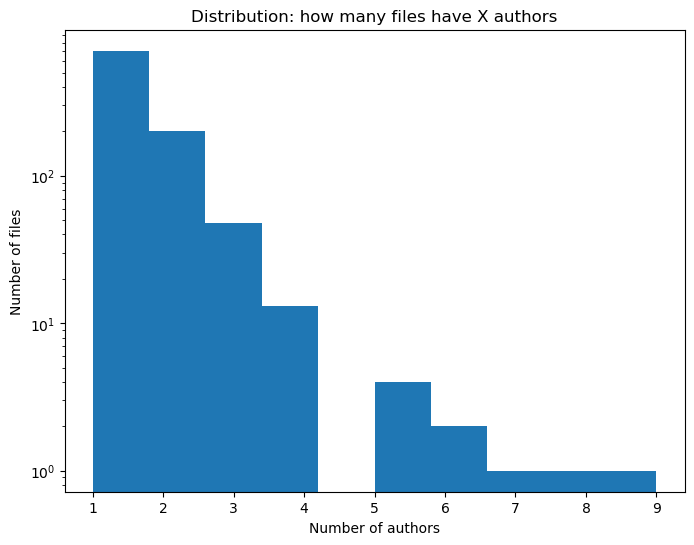

In [26]:
# visualization: number files (y) with n authors (x)
plt.figure(figsize=(8,6))
plt.title("Distribution: how many files have X authors", fontsize=12)
plt.hist(list(file_author_dictionary.values()), bins=10)
plt.yscale('log')
plt.xlabel("Number of authors", fontsize=10)
plt.ylabel("Number of files", fontsize=10)
plt.tick_params(axis='both', labelsize=10)
plt.show()

The plotted distribution indicates that there are a lot of files which have a small number of authors while there are a few that have a large number. In fact, most of the files of the repository for the analyzed timeframe have a single author. This could indicate that developers tend to work on the same files so a file is modified for the one who knows it the better, or that the files have been not modified since they were created. We would need to complement this result with other data to know what is the case, and spot possible ownership problems.

### Now, let's look at the following 3 packages in more detail:
1. `src/main/java/org/elasticsearch/search`
2. `src/main/java/org/elasticsearch/index`
3. `src/main/java/org/elasticsearch/action`

Create a function that, given the path of a package and a modification type (see class Modification above), returns a dictionary of authors => number, where the number counts the total lines added or removed or added+removed or added-removed (depending on the given Modification parameter), for the given package. To compute the value at the package level, you should aggregate the data per file.

Using the function defined above, visualize the author contributions (lines added + lines removed). The visualization should have the author on the x axis, and the total lines on the y axis. Sort the visualization in decreasing amount of contributions, i.e., the main author should be the first.

Compare the visualization for the 3 packages and comment.

In [20]:
def count_lines(operation, file):
    if operation == Modification.ADDED:
        return file.added_lines
    elif operation == Modification.REMOVED:
        return file.deleted_lines
    elif operation == Modification.DIFF:
        return file.added_lines - file.deleted_lines
    elif operation == Modification.TOTAL:
        return file.added_lines + file.deleted_lines
    else:
        raise "Invalid operation"
        
def get_modification_loc(operation, filepath):
    res = {}
    for c in repo.traverse_commits():
        author = c.author.name
        for mf in c.modified_files:
            # if the file has been removed, we checked if it was removed from the corresponding path
            if not mf.new_path:
                if mf.old_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf)
            # if the file has been added, we checked if it was added the to corresponding path
            elif not mf.old_path:
                if mf.new_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf)
            # otherwise, we checked if the file is/was in the corresponding path
            else:
                if mf.new_path.startswith(filepath) or mf.old_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf)

                            
    return {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}

In [21]:
# we get the contributions for the three indicated packages
filepath = "src\\main\\java\\org\\elasticsearch\\search"
author_contributions_search = get_modification_loc(Modification.TOTAL, filepath)

filepath = "src\\main\\java\\org\\elasticsearch\\index"
author_contributions_index = get_modification_loc(Modification.TOTAL, filepath)

filepath = "src\\main\\java\\org\\elasticsearch\\action"
author_contributions_action = get_modification_loc(Modification.TOTAL, filepath)

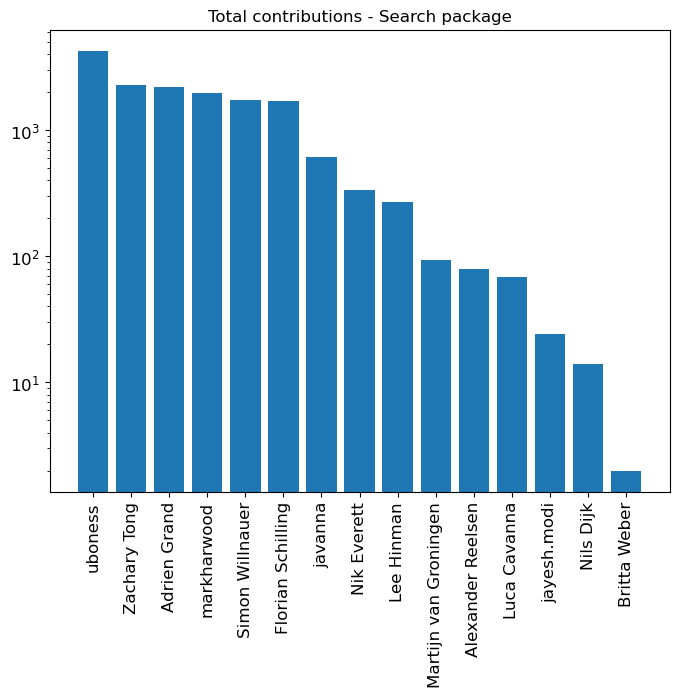

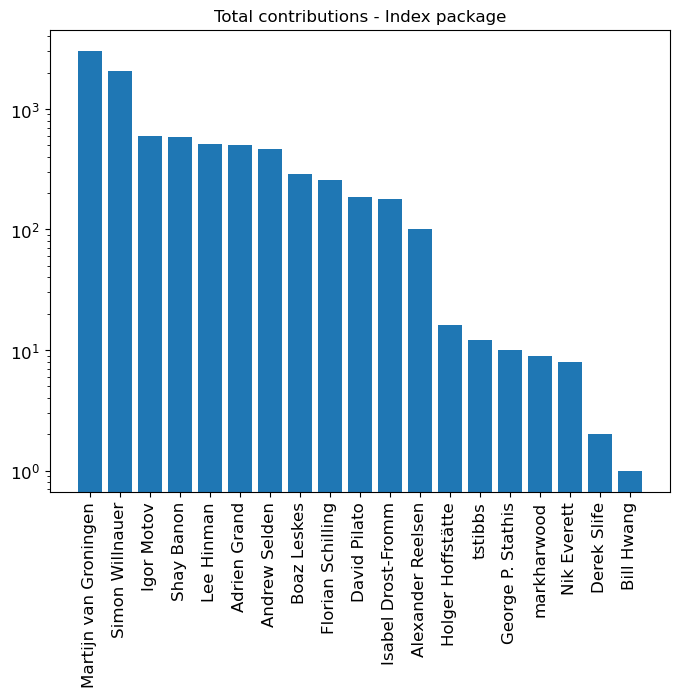

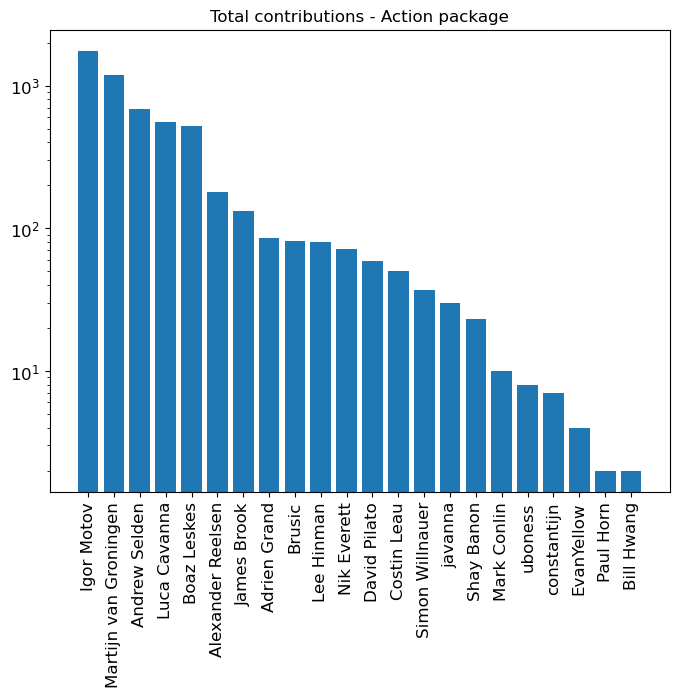

In [24]:
def plot_author_contributions(author_contributions, title):
    plt.figure(figsize=(8,6))
    plt.title(title, fontsize=12)
    plt.bar(author_contributions.keys(), author_contributions.values())
    plt.yscale('log')
    plt.xticks(rotation='vertical')
    plt.tick_params(axis='both', labelsize=12)
    plt.show()
    
plot_author_contributions(author_contributions_search, 'Total contributions - Search package')
plot_author_contributions(author_contributions_index, 'Total contributions - Index package')
plot_author_contributions(author_contributions_action, 'Total contributions - Action package')

The three packages show a similar tendency: there is a contributor which has done most of the contributions. This indicates that there is a person who has most of the knowledge for these packages. We can calculate the percentage of the contributions for the main authors by dividing their contributions by the total for the package. By doing this, we can see that the main authors did around the 30% of the modifications. The biggest gap with the rest of the developers happens for the index package, where the main contributor did almost the 35% of the changes.

## Task 2: Knowledge loss

We now want to analyze the knowledge loss when the main contributor of the analyzed project would leave. For this we will use the circle packaging layout introduced in the "Code as a Crime Scene" book. It should show how much of each file was written by the main contributor of _elasticsearch_ (according to the analysis above using `Modification.TOTAL`) and indicate which areas would be affected most when this contributor leaves the project. This assignment includes the necessary `knowledge_loss.html` file as well as the `d3` folder with the d3 dependencies. Your task is to create the `output.json` file according to the specification below. This file can then be visualized with the files provided.

For showing the visualization, once you have the output as `output.json` you should
* make sure to have the `knowledge_loss.html` file in the same folder
* start a local HTTP server in the same folder (e.g. with python `python3 -m http.server`, serving necessary for d3)
* open the served `knowledge_loss.html` and look at the visualization

For testing, you can use the provided `output.json` and should see a circle packaging layout with two circles, one big red, and one small white-red.

For the package you identify as the worst in terms of knowledge loss, investigate the author contributions using the function defined in the previous exercise and comment how the situation is, e.g. how big the gap between the main author and the second biggest contributor for the selected package is.

### Output Format for Visualization

Example:

* `root` is always the root of the tree
* `size` should be the total number of lines of contribution
* `weight` can be set to the same as `size`
* `ownership` should be set to the percentage of contributions from the main author (e.g. 0.98 for 98% if contributions coming from the main author)

```
{
  "name": "root",
  "children": [
    {
      "name": "test",
      "children": [
        {
          "name": "benchmarking",
          "children": [
            {
              "author_color": "red",
              "size": "4005",
              "name": "t6726-patmat-analysis.scala",
              "weight": 1.0,
              "ownership": 0.9,
              "children": []
            },
            {
              "author_color": "red",
              "size": "55",
              "name": "TreeSetIterator.scala",
              "weight": 0.88,
              "ownership": 0.2,
              "children": []
            }
          ]
        }
      ]
    }
  ]
}
```

### JSON Export

For exporting the data to JSON you can use the following snippet:

```
import json

with open("output.json", "w") as file:
    json.dump(tree, file, indent=4)
```

## Task 3: Code Churn Analysis

The third and last task is to analyze the code churn of the _elasticsearch_ project. For this analysis we look at the code churn, meaning the daily change in the total number of lines of the project. Visualize the code churn over time bucketing the data by day. Remember that you'll need to fill the gaps for days when there are no commits. Chose a filling strategy and justify it.

Look at the churn trend over time and identify two outliers. For each of them:
- identify if it was caused by a single or multiple commits (since you are bucketing the data by day)
- find the hash of the involved commit(s)
- find the involved files
- look at the actual diff

Based on the above, discuss if the outlier is a false positive or should be a reason for concern.

In [28]:
import pandas as pd
churn_dictionary = {}

# generate date range and initialize dictionary
dates = []
for c in repo.traverse_commits():
    dates.append(c.author_date.strftime("%Y/%m/%d"))
date_range = pd.date_range(start=min(dates), end=max(dates))
for date in date_range:
    churn_dictionary[date.strftime("%y/%m/%d")] = 0
    
# get modified lines for each commit and populate dictionary    
for c in repo.traverse_commits():
    date = c.author_date.strftime("%y/%m/%d")
    count = 0
    for mf in c.modified_files:
        count += mf.added_lines + mf.deleted_lines
    churn_dictionary[date] += count

In [29]:
# print keys
print(churn_dictionary.keys())

dict_keys(['13/03/16', '13/03/17', '13/03/18', '13/03/19', '13/03/20', '13/03/21', '13/03/22', '13/03/23', '13/03/24', '13/03/25', '13/03/26', '13/03/27', '13/03/28', '13/03/29', '13/03/30', '13/03/31', '13/04/01', '13/04/02', '13/04/03', '13/04/04', '13/04/05', '13/04/06', '13/04/07', '13/04/08', '13/04/09', '13/04/10', '13/04/11', '13/04/12', '13/04/13', '13/04/14', '13/04/15', '13/04/16', '13/04/17', '13/04/18', '13/04/19', '13/04/20', '13/04/21', '13/04/22', '13/04/23', '13/04/24', '13/04/25', '13/04/26', '13/04/27', '13/04/28', '13/04/29', '13/04/30', '13/05/01', '13/05/02', '13/05/03', '13/05/04', '13/05/05', '13/05/06', '13/05/07', '13/05/08', '13/05/09', '13/05/10', '13/05/11', '13/05/12', '13/05/13', '13/05/14', '13/05/15', '13/05/16', '13/05/17', '13/05/18', '13/05/19', '13/05/20', '13/05/21', '13/05/22', '13/05/23', '13/05/24', '13/05/25', '13/05/26', '13/05/27', '13/05/28', '13/05/29', '13/05/30', '13/05/31', '13/06/01', '13/06/02', '13/06/03', '13/06/04', '13/06/05', '13/0

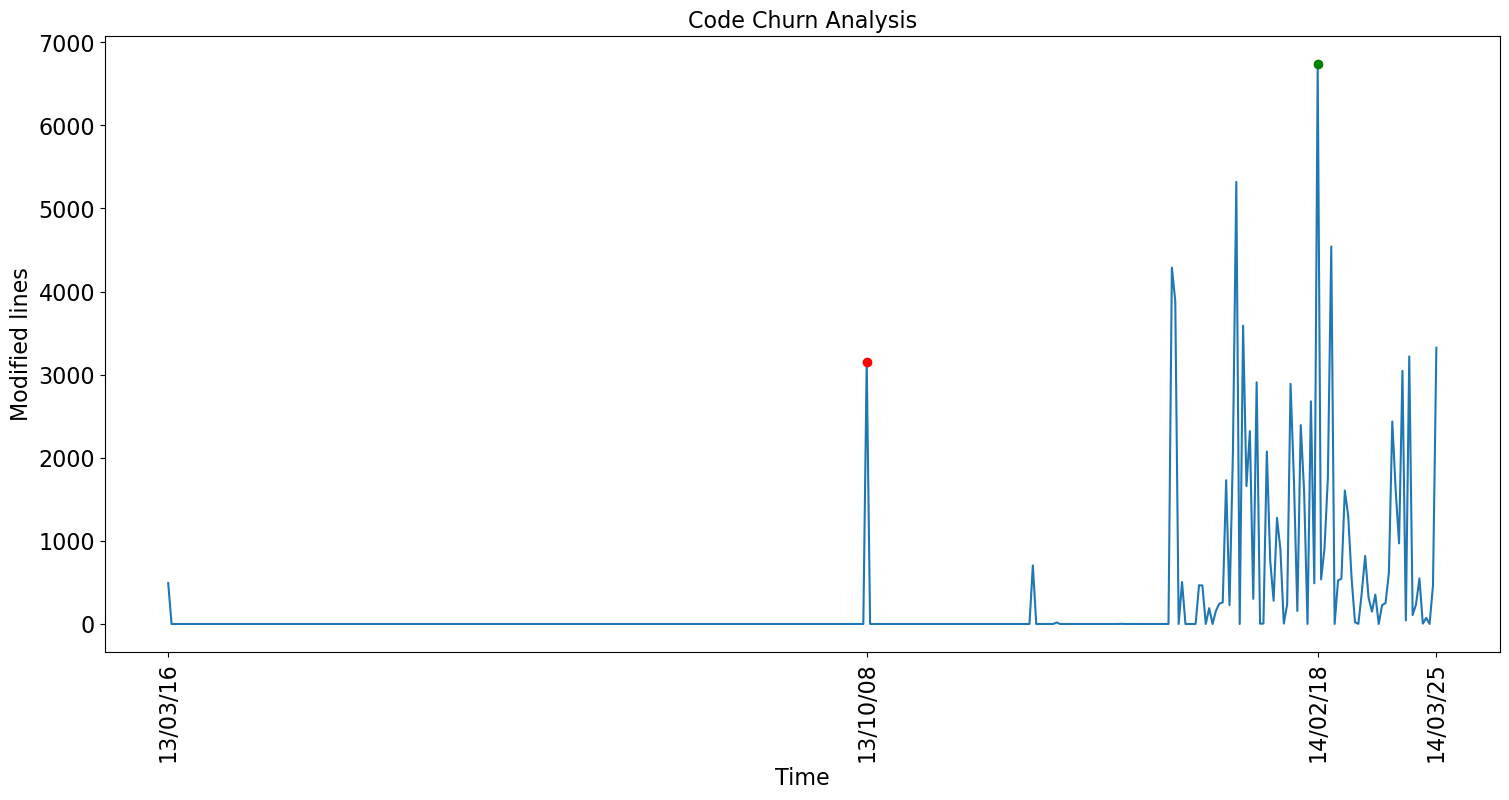

In [37]:
plt.figure(figsize=(18,8))
plt.ylabel("Modified lines", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.tick_params(axis='both', labelsize=16)
plt.title("Code Churn Analysis", fontsize=16)
plt.plot(churn_dictionary.keys(), churn_dictionary.values())
plt.xticks([list(churn_dictionary.keys())[0], '13/10/08', '14/02/18', 
            list(churn_dictionary.keys())[-1]], visible=True, rotation="vertical")
# mark the point
plt.plot('13/10/08', churn_dictionary['13/10/08'], 'ro')
plt.plot('14/02/18', churn_dictionary['14/02/18'], 'go')
plt.show()

In [12]:
# pydriller get the commits for hash list
def get_commits_for_hash_list(hash_list):
    commits = []
    for c in repo.traverse_commits():
        if c.hash in hash_list:
            print(c.hash)
            commits.append(c)
    return commits

# get the affected files for commit
def get_affected_files(commit):
    files = []
    for mf in commit.modified_files:
        if mf.new_path:
            files.append(mf.new_path)
        else:
            files.append(mf.old_path)
    print("Hash: ", commit.hash)
    print("Affected files: ", files)
    print("")

In [5]:
date_1_hashes = ['8c592101aee9640b42bd9336db33ad7f09d339d2']
date_2_hashes = ['0bce68e38e66a35ea82d1a331be5263e82451dd1',
                '776ace22734429edc1a9cc2379cf2626b7f81e07',
                '9538e7ddf0e0f7e67e72675b449ffbfe1ed63251',
                '14c4beb7197786cd2d3ba4d8abbc341f73dbb2e6',
                'a40f504b97222768bd0c462b9234bcdbfe723fa0',
                '77f37a9123cfde448bb9a4c19472182c844589cf',
                '91627fa57acad8a0f93a4a240c6162e58b832444']

In [6]:
commits_date_1 = get_commits_for_hash_list(date_1_hashes)
commits_date_2 = get_commits_for_hash_list(date_2_hashes)

8c592101aee9640b42bd9336db33ad7f09d339d2
0bce68e38e66a35ea82d1a331be5263e82451dd1
776ace22734429edc1a9cc2379cf2626b7f81e07
9538e7ddf0e0f7e67e72675b449ffbfe1ed63251
14c4beb7197786cd2d3ba4d8abbc341f73dbb2e6
a40f504b97222768bd0c462b9234bcdbfe723fa0
77f37a9123cfde448bb9a4c19472182c844589cf
91627fa57acad8a0f93a4a240c6162e58b832444


In [10]:
print("Commits for date 1:")
for c in commits_date_1:
    get_affected_files(c)

Commits for date 1:
Hash:  8c592101aee9640b42bd9336db33ad7f09d339d2
Affected files:  ['docs\\reference\\search\\suggesters.asciidoc', 'docs\\reference\\search\\suggesters\\completion-suggest.asciidoc', 'docs\\reference\\search\\suggesters\\context-suggest.asciidoc', 'src\\main\\java\\org\\apache\\lucene\\analysis\\PrefixAnalyzer.java', 'src\\main\\java\\org\\apache\\lucene\\search\\suggest\\analyzing\\XAnalyzingSuggester.java', 'src\\main\\java\\org\\apache\\lucene\\search\\suggest\\analyzing\\XFuzzySuggester.java', 'src\\main\\java\\org\\elasticsearch\\common\\geo\\GeoHashUtils.java', 'src\\main\\java\\org\\elasticsearch\\common\\geo\\GeoPoint.java', 'src\\main\\java\\org\\elasticsearch\\common\\geo\\GeohashPathIterator.java', 'src\\main\\java\\org\\elasticsearch\\common\\xcontent\\XContentBuilder.java', 'src\\main\\java\\org\\elasticsearch\\index\\mapper\\core\\CompletionFieldMapper.java', 'src\\main\\java\\org\\elasticsearch\\index\\query\\GeohashCellFilter.java', 'src\\main\\java\\

In [14]:
print("Commits for date 2:")
for c in commits_date_2:
    get_affected_files(c)

Commits for date 2:
Hash:  0bce68e38e66a35ea82d1a331be5263e82451dd1
Affected files:  ['src\\deb\\control\\postinst']

Hash:  776ace22734429edc1a9cc2379cf2626b7f81e07
Affected files:  ['src\\main\\java\\org\\elasticsearch\\rest\\action\\cat\\RestCatAction.java']

Hash:  9538e7ddf0e0f7e67e72675b449ffbfe1ed63251
Affected files:  ['src\\main\\java\\org\\elasticsearch\\search\\SearchService.java', 'src\\main\\java\\org\\elasticsearch\\search\\internal\\DefaultSearchContext.java']

Hash:  14c4beb7197786cd2d3ba4d8abbc341f73dbb2e6
Affected files:  ['pom.xml']

Hash:  a40f504b97222768bd0c462b9234bcdbfe723fa0
Affected files:  ['src\\main\\java\\org\\elasticsearch\\index\\query\\SimpleQueryParser.java', 'src\\main\\java\\org\\elasticsearch\\index\\query\\SimpleQueryStringBuilder.java', 'src\\main\\java\\org\\elasticsearch\\index\\query\\SimpleQueryStringParser.java', 'src\\test\\java\\org\\elasticsearch\\search\\query\\SimpleQueryTests.java']

Hash:  77f37a9123cfde448bb9a4c19472182c844589cf
Affec